In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

# Compare cluster similarity with

In [158]:
import scipy.stats

def get_cluster_sizes(adata, cluster_column):
    '''Get a data frame of cluster sizes.'''
    cell_mtx = pd.DataFrame(np.ones((adata.shape[0], 1), dtype=int), 
                            index=adata.obs[cluster_column], columns=['size'])
    return cell_mtx.groupby(by=cluster_column).sum()
    
def get_cluster_mean_expression_matrix(adata, cluster_column):
    '''Get a dataframe of mean gene expression of each cluster.'''
    cell_exp_mtx = pd.DataFrame(adata.X, index=adata.obs[cluster_column], columns=adata.var.index)    
    cluster_mean_exp = cell_exp_mtx.groupby(by=cluster_column).mean()
    return cluster_mean_exp

def get_cluster_expression_std_matrix(adata, cluster_column):
    '''Get a dataframe of gene expression standard deviations of each cluster.'''
    cell_exp_mtx = pd.DataFrame(adata.X, index=adata.obs[cluster_column], columns=adata.var.index)    
    cluster_exp_std = cell_exp_mtx.groupby(by=cluster_column).std()
    return cluster_exp_std

def get_cluster_expression_fraction_matrix(adata, cluster_column, exp_threshold=0):
    '''Get a dataframe of the fraction of cells that express each gene in each cluster.'''
    cell_exp_mtx = pd.DataFrame(adata.X, index=adata.obs[cluster_column], columns=adata.var.index)    
    cluster_exp_fraction = (cell_exp_mtx > exp_threshold).groupby(by=cluster_column).mean()
    return cluster_exp_fraction

def differential_expression_score_between_two_clusters(cluster_size1, cluster_size2,
        mean_exps1, mean_exps2, std_exps1, std_exps2, exp_fracs1, exp_fracs2,
        fold_change_threshold=2, pval_threshold=1e-2, exp_frac_threshold=0.5,
        relative_exp_threshold=0.7, pvalue_baseline=np.exp(-20)):
    '''Calculate the differential expression score between two clusters.'''
    # Mask of differentially expressed genes
    N_genes = len(mean_exps1)
    de_masks = np.ones(N_genes, dtype=bool)
    
    # Calculate the fold changes of mean expressions
    fold_changes = mean_exps2 / (mean_exps1 + 1e-20)
    de_masks = de_masks & ((fold_changes > fold_change_threshold) | (fold_changes < (1 / fold_change_threshold)))
    
    # Calculate the p-values using t-test
    t_stats, pvals = scipy.stats.ttest_ind_from_stats(mean1=mean_exps1, std1=std_exps1, 
                            nobs1=cluster_size1 * np.ones(N_genes, dtype=int), mean2=mean_exps2, std2=std_exps2,
                            nobs2=cluster_size2 * np.ones(N_genes, dtype=int))
    de_masks = de_masks & (pvals < pval_threshold)
    
    # The marker genes should be generally expressed in at least one cluster
    de_masks = de_masks & (np.maximum(exp_fracs1, exp_fracs2) > exp_frac_threshold)
    
    # The marker genes should have bimodal expression patterns
    relative_exp = np.absolute(exp_fracs1 - exp_fracs2) / (np.maximum(exp_fracs1, exp_fracs2) + 1e-20)
    de_masks = de_masks & (relative_exp > relative_exp_threshold)
    
    # Calculate the differential expression scores for each gene
    de_scores = -np.log(pvals + pvalue_baseline) * de_masks

    return np.sum(de_scores)

def calculate_differential_expression_score_matrix(adata, cluster_column, exp_threshold=0):
    '''Calcualte a matrix of differential expression scores between clusters.'''
    # Calculate the matrices of cluster properties
    cluster_sizes = get_cluster_sizes(adata, cluster_column)
    cluster_mean_exp = get_cluster_mean_expression_matrix(adata, cluster_column)
    cluster_exp_std = get_cluster_expression_std_matrix(adata, cluster_column)
    cluster_exp_fraction = get_cluster_expression_fraction_matrix(adata, cluster_column, 
                                                                  exp_threshold=exp_threshold)
    
    # Initialize the DE score matrix
    cluster_ids = np.array(cluster_sizes.index)
    N_clusters = len(cluster_ids)
    de_score_mtx = pd.DataFrame(np.zeros((N_clusters, N_clusters)), index=cluster_ids, columns=cluster_ids)
    
    # Fill the DE score matrix
    for i in range(N_clusters):
        cluster_id1 = cluster_ids[i]
        cluster_size1 = int(cluster_sizes.loc[cluster_id1])
        mean_exps1 = np.array(cluster_mean_exp.loc[cluster_id1])
        std_exps1 = np.array(cluster_exp_std.loc[cluster_id1])
        exp_fracs1 = np.array(cluster_exp_fraction.loc[cluster_id1])

        for j in range(i + 1, N_clusters):
            cluster_id2 = cluster_ids[j]
            cluster_size2 = int(cluster_sizes.loc[cluster_id2])
            mean_exps2 = np.array(cluster_mean_exp.loc[cluster_id2])
            std_exps2 = np.array(cluster_exp_std.loc[cluster_id2])
            exp_fracs2 = np.array(cluster_exp_fraction.loc[cluster_id2])
    
            de_score = differential_expression_score_between_two_clusters(cluster_size1, cluster_size2,
                mean_exps1, mean_exps2, std_exps1, std_exps2, exp_fracs1, exp_fracs2)
        
            de_score_mtx.loc[cluster_id1, cluster_id2] = de_score
            de_score_mtx.loc[cluster_id2, cluster_id1] = de_score
    
    return de_score_mtx

def calculate_correlation_matrix(adata, cluster_column):
    '''Calculate gene expression correlations between clusters.'''
    cluster_mean_exp = get_cluster_mean_expression_matrix(adata, cluster_column)
    
    # Initialzie the correlation matrix
    cluster_ids = np.array(cluster_mean_exp.index)
    N_clusters = len(cluster_ids)
    correlation_mtx = pd.DataFrame(np.ones((N_clusters, N_clusters)), index=cluster_ids, columns=cluster_ids)
    
    # Fill the correlation matrix
    for i in range(N_clusters):
        cluster_id1 = cluster_ids[i]
        mean_exps1 = np.array(cluster_mean_exp.loc[cluster_id1])
        
        for j in range(i + 1, N_clusters):
            cluster_id2 = cluster_ids[j]
            mean_exps2 = np.array(cluster_mean_exp.loc[cluster_id2])
            
            r, p = scipy.stats.pearsonr(mean_exps1, mean_exps2)

            correlation_mtx.loc[cluster_id1, cluster_id2] = r
            correlation_mtx.loc[cluster_id2, cluster_id1] = r
            
    return correlation_mtx

In [167]:
# Functions for sorting distance matrices

from scipy.spatial.distance import squareform
from fastcluster import linkage

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

def sort_distance_dataframe(df):
    ids = list(df.index)
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(np.array(df))
    ordered_ids = [ids[i] for i in res_order]
    return pd.DataFrame(ordered_dist_mat, index=ordered_ids, columns=ordered_ids)

In [38]:
# Load the normalized raw counts of the MOp 254 dataset. The counts are normalized by cell volumes.
data_path_raw = '/home/xingjie/ResearchProjects/whole_brain/integration/test_data/preprocessed_integration_test_data/MOp_MERFISH_raw.h5ad'
adatde_masksa_254_raw = sc.read_h5ad(data_path_raw)

# Get the normalized-log expressions
adata_254_log = adata_254_raw.copy()
sc.pp.normalize_total(adata_254_log, target_sum=1e4)
sc.pp.log1p(adata_254_log)

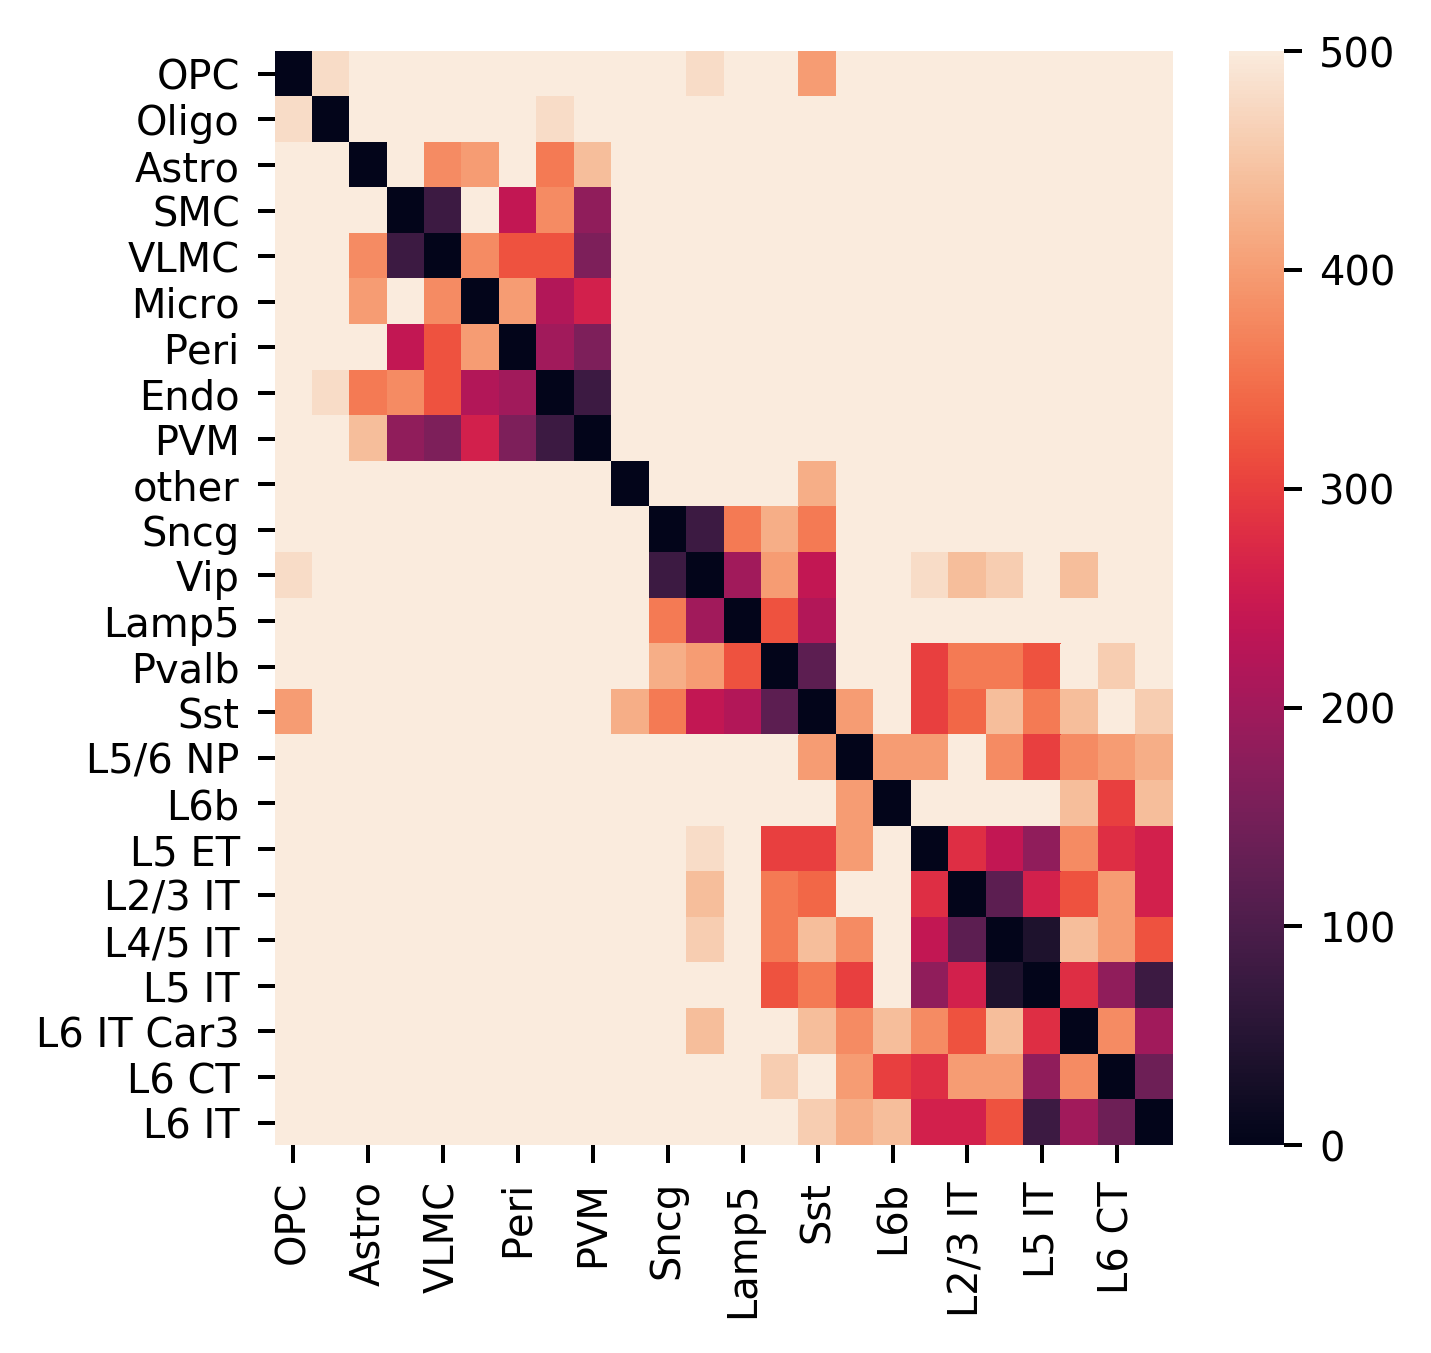

In [180]:
de_score_mtx = calculate_differential_expression_score_matrix(adata_254_log, 'subclass_MERFISH', exp_threshold=0)
de_score_mtx_sorted = sort_distance_dataframe(de_score_mtx)
sns.heatmap(de_score_mtx_sorted, vmax=500, vmin=0)

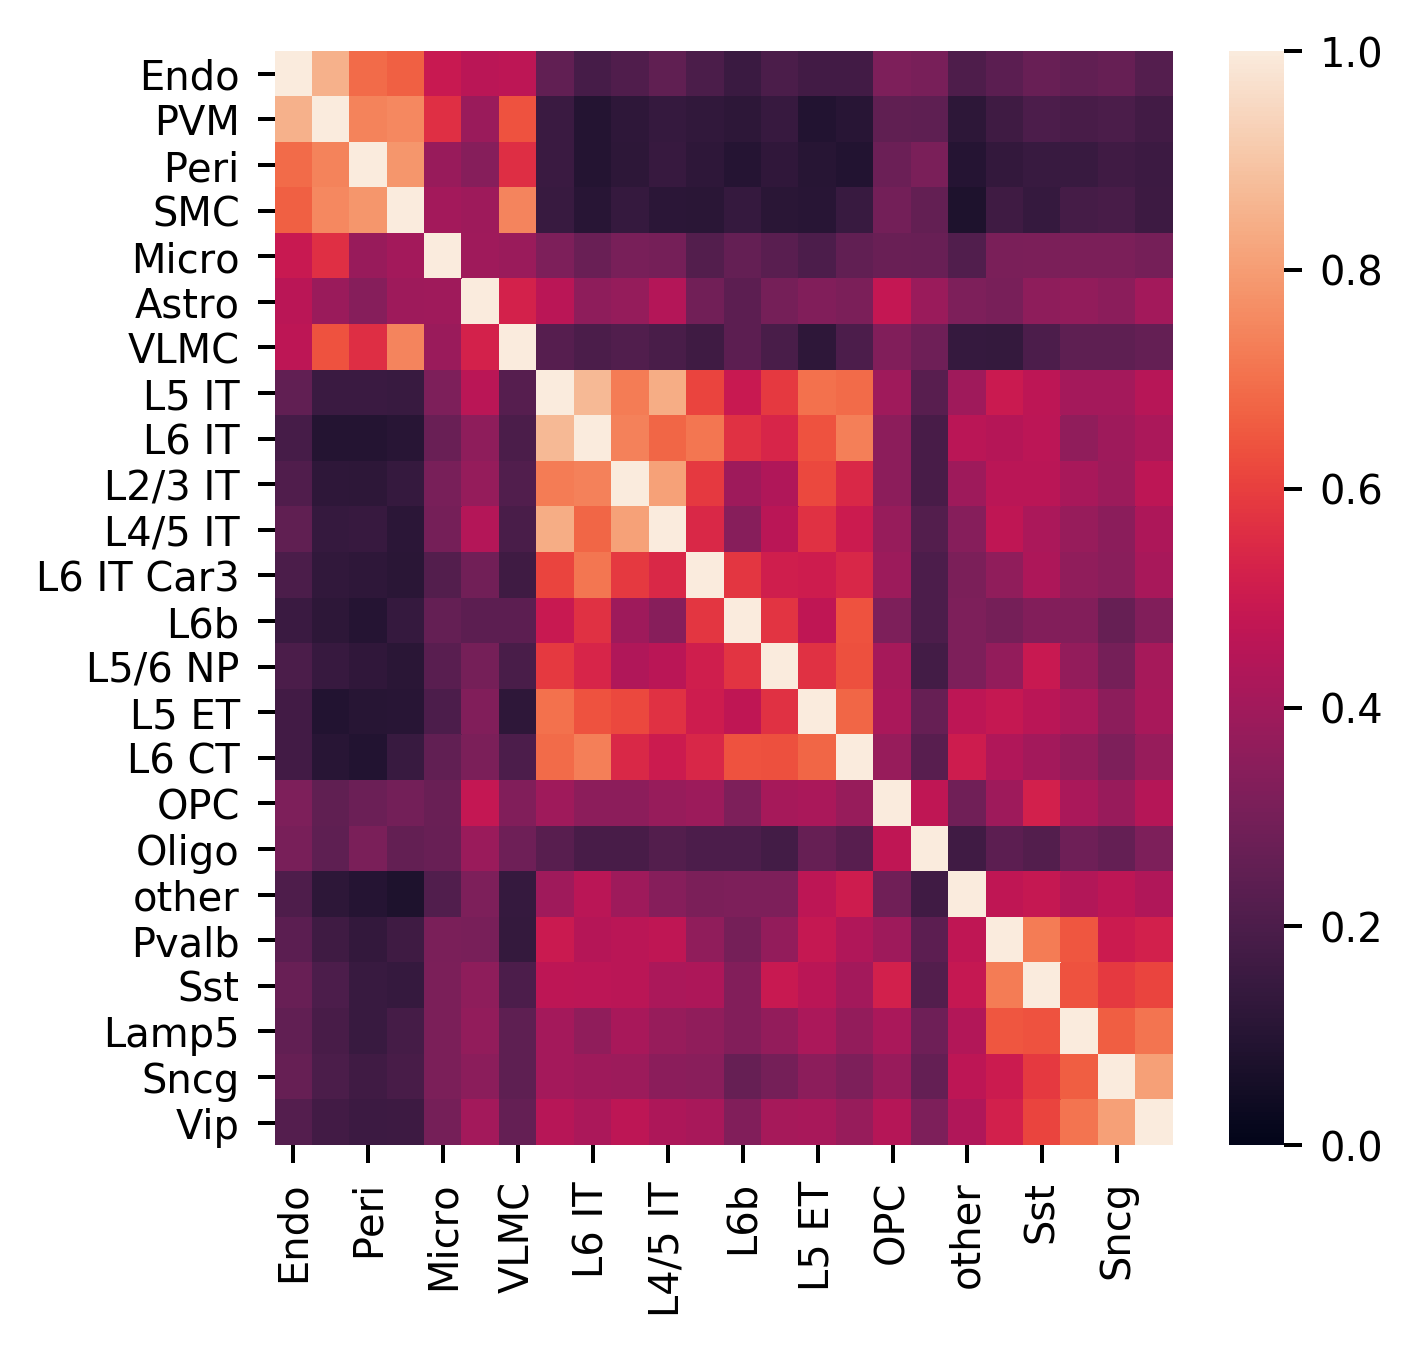

In [182]:
correlation_mtx = calculate_correlation_matrix(adata_254_log, 'subclass_MERFISH')
correlation_mtx_sorted = 1 - sort_distance_dataframe(1 - correlation_mtx)
sns.heatmap(correlation_mtx_sorted, vmax=1, vmin=0)